# DSSC geometry

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import extra_data as ed
from extra_data.read_machinery import find_proposal

import xarray as xr

In [2]:
proposal = 2711
darkrunNB = 203
runlist = [(204, 203), (205, 203), (206, 203)]

In [3]:
root = find_proposal(f'p{proposal:06d}')
path = root + '/usr/processed_runs/'
fnames = [path + f'r{r:04d}/*.h5'for r,d in runlist]

In [4]:
fnames

['/gpfs/exfel/exp/SCS/202022/p002711/usr/processed_runs/r0204/*.h5',
 '/gpfs/exfel/exp/SCS/202022/p002711/usr/processed_runs/r0205/*.h5',
 '/gpfs/exfel/exp/SCS/202022/p002711/usr/processed_runs/r0206/*.h5']

In [5]:
data1 = xr.open_mfdataset(fnames[0], parallel=True, join='inner')#.load().close()
data2 = xr.open_mfdataset(fnames[1], parallel=True, join='inner')#.load().close()
data3 = xr.open_mfdataset(fnames[2], parallel=True, join='inner')#.load().close()

img = (data1['DSSC'].squeeze().values
       + data2['DSSC'].squeeze().values
       + data3['DSSC'].squeeze().values)/3.0

In [6]:
data1.close()
data2.close()
data3.close()

In [15]:
from extra_geom import DSSC_1MGeometry
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

class DSSCCreateGeom():
    def __init__(self, img_data, quad_pos=None, geom_file=None):
        self.img_data = img_data
        self.period_x = 33.0
        self.period_y = 33.0
        self.vmin = 0.0
        self.vmax = 1.0
        
        self.output = widgets.Output()
        plt.close('DSSC')
        #with self.output:
        self.fig, self.ax = plt.subplots(1, 1, num='DSSC', figsize=(6,6))

        if quad_pos is None:
            self.quad_pos_Q1_x =  -130
            self.quad_pos_Q1_y =  5
            self.quad_pos_Q2_x =  -130
            self.quad_pos_Q2_y =  -125
            self.quad_pos_Q3_x =  5
            self.quad_pos_Q3_y =  -125
            self.quad_pos_Q4_x =  5
            self.quad_pos_Q4_y =  5
        else:
            self.quad_pos_Q1_x =  quad_pos[0][0]
            self.quad_pos_Q1_y =  quad_pos[0][1]
            self.quad_pos_Q2_x =  quad_pos[1][0]
            self.quad_pos_Q2_y =  quad_pos[1][1]
            self.quad_pos_Q3_x =  quad_pos[2][0]
            self.quad_pos_Q3_y =  quad_pos[2][1]
            self.quad_pos_Q4_x =  quad_pos[3][0]
            self.quad_pos_Q4_y =  quad_pos[3][1]
            
        if geom_file is None:
            self.geom_file = "/gpfs/exfel/exp/SCS/201901/p002212/usr/Shared/Training_UP-2719/geometry/dssc_geom_AS_aug20.h5"
        else:
            self.geom_file = geom_file
            
        self.initWidgets()
        self.UpdateFig(is_init=True)
        display(self.control)
    
    def quad_pos(self):
        return [(self.quad_pos_Q1_x, self.quad_pos_Q1_y),
                (self.quad_pos_Q2_x, self.quad_pos_Q2_y),
                (self.quad_pos_Q3_x, self.quad_pos_Q3_y),
                (self.quad_pos_Q4_x, self.quad_pos_Q4_y)]
    
    def UpdateFig(self, is_init=False):
        
        sw = self.widgets
        
        self.quad_pos_Q1_x = sw['Q1_x'].value
        self.quad_pos_Q1_y = sw['Q1_y'].value        
        self.quad_pos_Q2_x = sw['Q2_x'].value
        self.quad_pos_Q2_y = sw['Q2_y'].value        
        self.quad_pos_Q3_x = sw['Q3_x'].value
        self.quad_pos_Q3_y = sw['Q3_y'].value        
        self.quad_pos_Q4_x = sw['Q4_x'].value
        self.quad_pos_Q4_y = sw['Q4_y'].value        
        
        self.g = DSSC_1MGeometry.from_h5_file_and_quad_positions(self.geom_file,
                                                                 self.quad_pos())
        
        self.vmin = sw['vmin'].value
        self.vmax = sw['vmax'].value
        self.period_x = sw['period_x'].value
        self.period_y = sw['period_y'].value
        
        if not(is_init):
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        
        self.ax.cla()
        self.g.plot_data_cartesian(self.img_data, vmin=self.vmin, vmax=self.vmax, ax=self.ax,
                                   colorbar=False)
        for i in range(-30, 30):
            self.ax.axvline(self.period_x*i, color='w', alpha=0.3)
            self.ax.axhline(self.period_y*i, color='w', alpha=0.3)
        
        if not(is_init):
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
            
        self.fig.canvas.draw()
    
    def initWidgets(self):
        style = {'description_width': 'initial'}
        layout = {}  # max_width': '300px'}

        self.Update = widgets.Button(
            description='Update',
        )

        @self.Update.on_click
        def plot_on_click(b):
            self.UpdateFig()
        
        self.widgets = {}
        
        self.widgets['period_x'] = widgets.BoundedFloatText(
            value=self.period_x,
            min=0,
            max=1000,
            description='Period x (pm):',
            style=style,
            layout=layout
        )

        self.widgets['period_y'] = widgets.BoundedFloatText(
            value=self.period_y,
            min=0,
            max=1000,
            description='Period y (pm):',
            style=style,
            layout=layout
        )
        
        period = HBox([self.widgets['period_x'], self.widgets['period_y']])
       
        self.widgets['vmin'] = widgets.BoundedFloatText(
            value=self.vmin,
            min=-1000,
            max=1000,
            description='vmin',
            style=style,
            layout=layout
        )

        self.widgets['vmax'] = widgets.BoundedFloatText(
            value=self.vmax,
            min=-1000,
            max=1000,
            description='vmax',
            style=style,
            layout=layout
        )

        self.widgets['Q1_x'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q1_x,
            min=-1000,
            max=1000,
            description='Q1 x',
            style=style,
            layout=layout
        )
        self.widgets['Q1_y'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q1_y,
            min=-1000,
            max=1000,            
            description='Q1 y',
            style=style,
            layout=layout
        )
        Q1 = HBox([self.widgets['Q1_x'], self.widgets['Q1_y']])
        
        self.widgets['Q2_x'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q2_x,
            min=-1000,
            max=1000,            
            description='Q2 x',
            style=style,
            layout=layout
        )
        self.widgets['Q2_y'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q2_y,
            min=-1000,
            max=1000,            
            description='Q2 y',
            style=style,
            layout=layout
        )
        Q2 = HBox([self.widgets['Q2_x'], self.widgets['Q2_y']])
        
        self.widgets['Q3_x'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q3_x,
            min=-1000,
            max=1000,            
            description='Q3 x',
            style=style,
            layout=layout
        )
        self.widgets['Q3_y'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q3_y,
            min=-1000,
            max=1000,            
            description='Q3 y',
            style=style,
            layout=layout
        )
        Q3 = HBox([self.widgets['Q3_x'], self.widgets['Q3_y']])
        
        self.widgets['Q4_x'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q4_x,
            min=-1000,
            max=1000,            
            description='Q4 x',
            style=style,
            layout=layout
        )
        self.widgets['Q4_y'] = widgets.BoundedFloatText(
            value=self.quad_pos_Q4_y,
            min=-1000,
            max=1000,            
            description='Q4 y',
            style=style,
            layout=layout
        )
        Q4 = HBox([self.widgets['Q4_x'], self.widgets['Q4_y']])
        
        vminmax = HBox([self.widgets['vmin'], self.widgets['vmax']])
        
        self.control = HBox([#self.output,
            VBox([self.Update, vminmax, period, Q1, Q2, Q3, Q4])])
        

In [16]:
quad_pos = [(-123.519014, 3.120173999999999),
            (-126.18, -118.248812),
            (-0.600638, -119.65706899999999),
            (1.6054490000000001, 1.4930180000000064)]


<IPython.core.display.Javascript object>


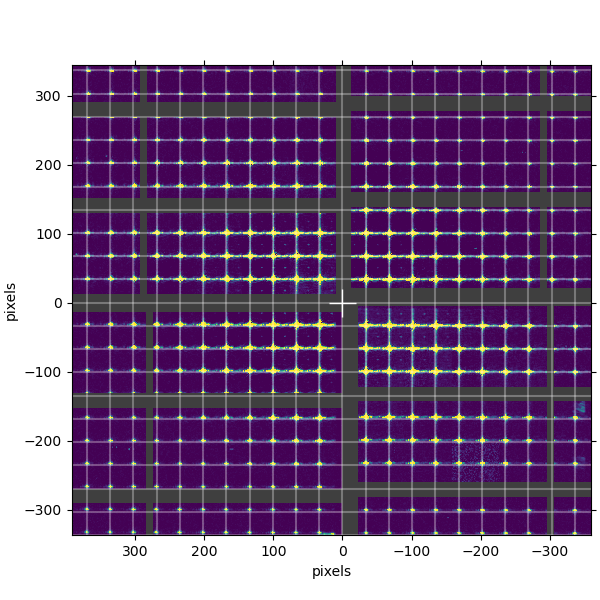

In [17]:
d = DSSCCreateGeom(img, quad_pos)